# Physical track clustering

You have track hypotheses (e-, e+, μ-, μ+) that are fits to physical tracks (actual particle trajectories). Multiple hypotheses can be fit to the same physical track, and you want to ensure there's exactly one physical downstream electron track—not one hypothesis, but one actual track.
The Fundamental Problem
You can't count PDGs because:

- 4 hypotheses might succeed on 1 physical track → overcounting
- Some hypotheses fail → undercounting or ambiguity
- trkqual isn't reliable for hypothesis selection and is not discrete

Possible Discrete Approaches
1. Cluster by Entrance Kinematics
Track hypotheses for the same physical track will have nearly identical entrance positions and directions at the tracker front. Different physical tracks will not.
python# At tracker entrance (TT_Front), extract position/momentum for each hypothesis
```
# Cluster hypotheses with matching (x, y, z, px, py, pz) within tolerance
# Count clusters, not hypotheses
```
This gives you a discrete count of physical tracks, independent of fit success/failure.



In [16]:
import pickle
import awkward as ak
import matplotlib.pyplot as plt
from pyutils.pyprint import Print
from pyutils.pylogger import Logger
from pyutils.pyselect import Select
from pyutils.pycut import CutManager
from pyutils.pyplot import Plot

printer = Print()
selector = Select()
logger = Logger()
plotter = Plot()

[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1
[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


In [112]:
def append_array(data, arr, name):
    """Helper to append arrays/masks to dev field 
    This is useful for debugging and development
    Must be trk or trkfit level
    """
    try:
        if "dev" not in ak.fields(data):
            # Initialise dev field - structure will be determined by first array added
            data = ak.with_field(data, ak.zip({name: arr}, depth_limit=1), "dev")
        else: 
            # Add new field to existing 'dev' record
            new_dev = ak.with_field(data.dev, arr, name)
            data = ak.with_field(data, new_dev, "dev")
        return data
    except Exception as e:
        print("Error appending '{name}' to data array: {e}")
        raise e

In [3]:
def load(file_name):
    try:
        with open(file_name, "rb") as f:
            return pickle.load(f)
    except Exception as e:
        print(f"[ERROR] {e}")

cry_data = load("/home/mu2ecrv/sgrant-ana/misc-ana/results_cry.pkl")
# ce_data = load("/home/mu2ecrv/sgrant-ana/misc-ana/results_signal.pkl")

In [98]:
has_trk = ak.any(cry_data["trk"]["trk.pdg"], axis=-1)
cry_data = cry_data[has_trk]

In [77]:
def def_no_duplicates(data):
    ###################################################
    # No duplicate hypotheses
    # This implies multiple clusters of tracker hits
    ###################################################
    # Count unique pdgs
    pdgs = data["trk"]["trk.pdg"]
    n_unique_pdgs = ak.num(ak.run_lengths(ak.sort(pdgs)), axis=-1)
    n_total_pdgs = ak.num(pdgs, axis=-1)
    has_duplicates = n_unique_pdgs < n_total_pdgs
    no_duplicates = ~has_duplicates

    # Append for debugging
    data = _append_array(data, no_duplicates, "no_duplicates")
    
    return data

cry_data = def_no_duplicates(cry_data)

In [78]:
printer.print_n_events(
    cry_data,
    n_events = 1
)

[pyprint] ⭐️ Printing 1 event(s)...

-------------------------------------------------------------------------------------
evt.run: 1202
evt.subrun: 68
evt.event: 22194
trk.trk.pdg: [11, 11, -11, -11, 11, 13, -13, 13, -13, -13, -13]
trk.trkqual.result: [0.793, 0.84, 0.452, 0.0936, 0.0125, ..., 0.0127, 0.148, 0.0586, 0.102, 0.0143]
trkfit.trksegs.mom.fCoordinates.fX: [[52.7, -29.6, -2.86, -42.3, 29.7], [...], ..., [6.86, 2.82, -8.85, -30.2]]
trkfit.trksegs.mom.fCoordinates.fY: [[13.3, 37.8, 48.6, 20.7, -58.2], [-44.1, ...], ..., [-30.6, 30.5, 35.9, 18.8]]
trkfit.trksegs.mom.fCoordinates.fZ: [[68.9, 72.7, 72.7, 72.9, 58.6], [80.6, ...], ..., [-52.6, -51, -51.4, -47.7]]
trkfit.trksegs.pos.fCoordinates.fX: [[80.1, 176, 210, 121, -68.6], [-126, ..., 24.8], ..., [141, -55, -97.2, -3.06]]
trkfit.trksegs.pos.fCoordinates.fY: [[289, 569, 478, 622, 296], [480, 470, ..., 480], ..., [549, 532, 492, 333]]
trkfit.trksegs.pos.fCoordinates.fZ: [[-3.25e+03, 10.1, -1.63e+03, 1.64e+03, -5.97e+03], ..., [

In [83]:
def define_spread(data):
    # Get track segments at tracker entrance
    at_trk_front = selector.select_surface(data["trkfit"], surface_name="TT_Front")
    front_segs = data["trkfit"]["trksegs"][at_trk_front]
    
    # Extract entrance position for each hypothesis
    # These are the spatial coordinates at TT_Front
    x_front = front_segs["pos"]["fCoordinates"]["fX"]
    y_front = front_segs["pos"]["fCoordinates"]["fY"]
    z_front = front_segs["pos"]["fCoordinates"]["fZ"]
    
    # # For hypotheses of the SAME physical track:
    # # positions will be identical (within fit precision, ~mm)
    # # 
    # # Strategy: Take the first (or any) valid hypothesis's entrance position
    # # as the "track anchor", then count unique anchors
    
    # Flatten to get one position per hypothesis, then check variance
    x_first = ak.firsts(x_front, axis=-1)  # one x per hypothesis
    y_first = ak.firsts(y_front, axis=-1)
    
    # Group hypotheses by matching (x,y) at entrance
    # If all hypotheses have the same entrance (within tolerance), it's 1 track
    x_spread = ak.max(x_first, axis=-1) - ak.min(x_first, axis=-1)
    y_spread = ak.max(y_first, axis=-1) - ak.min(y_first, axis=-1)
    r_spread = (x_spread**2 + y_spread**2) ** 0.5

    data = append_array(data, x_spread, "x_spread")
    data = append_array(data, y_spread, "y_spread")
    data = append_array(data, r_spread, "r_spread")
    
    return data

cry_data = define_spread(cry_data)
printer.print_n_events(cry_data["dev"])

[pyselect] ✅ Returning mask for trksegs with sid = 0
[pyprint] ⭐️ Printing 1 event(s)...

-------------------------------------------------------------------------------------
x_front: [[210], [-121], [-118], [212], [-15.3], ..., [-122], [-113], [209], [-55]]
x_first: [210, -121, -118, 212, -15.3, 210, -60.9, -122, -113, 209, -55]
no_duplicates: False
x_spread: 333.8670654296875
y_spread: 146.95867919921875
r_spread: 364.77947998046875
-------------------------------------------------------------------------------------



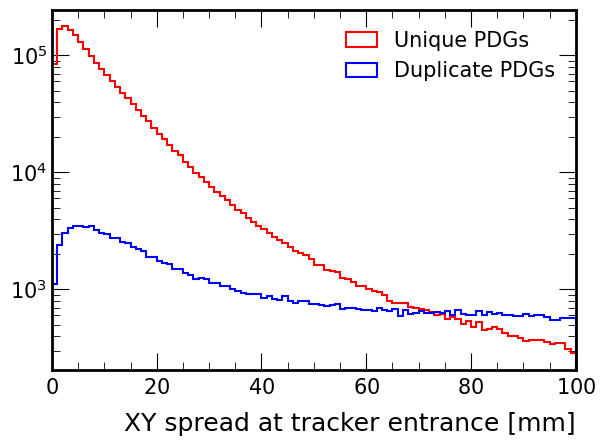

In [108]:
no_duplicates = cry_data["dev"]["no_duplicates"]

plotter.plot_1D_overlay(
    {
        "Unique PDGs" : ak.flatten(cry_data["dev"]["r_spread"][no_duplicates], axis=None),
        "Duplicate PDGs" : ak.flatten(cry_data["dev"]["r_spread"][~no_duplicates], axis=None),
    },
    nbins = 100,
    xmin = 0,
    xmax = 100,
    log_y = True,
    xlabel = "XY spread at tracker entrance [mm]",
    norm_by_area = False
)

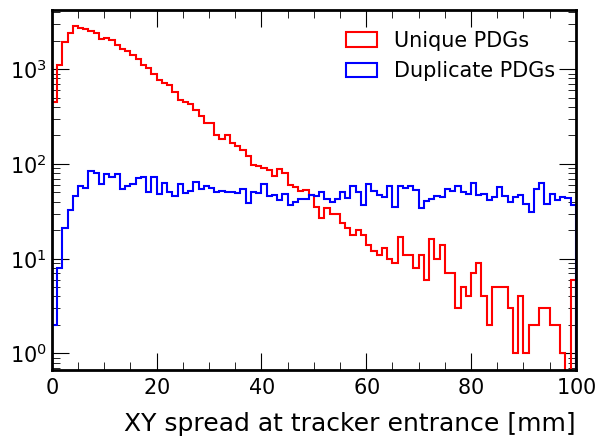

In [107]:
any_trkqual = ak.any(cry_data["trk"]["trkqual.result"] > 0.99, axis=-1)
cry_data = append_array(cry_data, any_trkqual, "any_trkqual")
# printer.print_n_events(cry_data[any_trkqual], 5)

plotter.plot_1D_overlay(
    {
        "Unique PDGs" : ak.flatten(cry_data["dev"]["r_spread"][(no_duplicates & any_trkqual)], axis=None),
        "Duplicate PDGs" : ak.flatten(cry_data["dev"]["r_spread"][(~no_duplicates & any_trkqual)], axis=None),
    },
    nbins = 100,
    xmin = 0,
    xmax = 100,
    log_y = True,
    xlabel = "XY spread at tracker entrance [mm]",
    norm_by_area = False
)

In [124]:
condition = (cry_data["dev"]["r_spread"] > 70) & no_duplicates & any_trkqual
weird_events = cry_data[condition ] # cry_data["dev"]["r_spread"][no_duplicates] > 70]
weird_events = ak.drop_none(weird_events)
# cry_data = append_ar?ray(cry_data, weird_events, "weird_events")
print(weird_events)
printer.print_n_events(
    weird_events,
    n_events = 5
)

[{evt: {run: 1202, subrun: 1850, ...}, trk: {...}, trkfit: {...}, ...}, ...]
[pyprint] ⭐️ Printing 5 event(s)...

-------------------------------------------------------------------------------------
evt.run: 1202
evt.subrun: 1850
evt.event: 385065
trk.trk.pdg: [-11, -13, 13]
trk.trkqual.result: [0.991, 0.53, 0.0307]
trkfit.trksegs.mom.fCoordinates.fX: [[79.8, -98.4, 83.4, 25.9, 46.8, -35], ..., [-78.3, 98.5, ..., 33.5, -76.5]]
trkfit.trksegs.mom.fCoordinates.fY: [[65.4, 32.2, 64.3, 90.4, -83.9, -85.9], ..., [-66.4, -29, ..., 88.5, -57]]
trkfit.trksegs.mom.fCoordinates.fZ: [[29.3, 28.4, 21.5, 50.5, 47.6, 51.8], ..., [-28.3, -27.2, ..., -52.7, 42.9]]
trkfit.trksegs.pos.fCoordinates.fX: [[102, 194, 103, 4.82, 572, 590], ..., [92.5, 197, 102, ..., 525, 595, 106]]
trkfit.trksegs.pos.fCoordinates.fY: [[282, -229, 282, 132, 197, -72.8], ..., [285, -226, 282, ..., 257, -65, 327]]
trkfit.trksegs.pos.fCoordinates.fZ: [[-2.69e+03, -2.87e+03, -3.16e+03, 10.1, -1.63e+03, 1.64e+03], ..., [...]]
trk

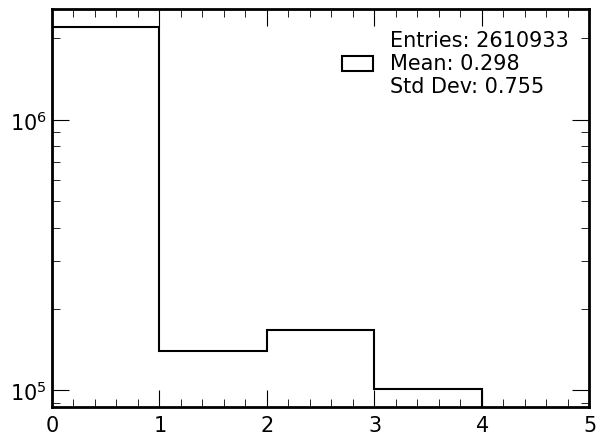

In [43]:
plotter.plot_1D(
    ak.num(cry_data["trk"]["trk.pdg"], axis=-1) % 4,
    nbins = 5,
    xmin = 0,
    xmax = 5,
    show = True,
    log_y = True,
)

In [69]:
printer.print_n_events(
    cry_data[(ak.num(cry_data["trk"]["trk.pdg"], axis=-1) <= 4)],
    n_events = 1
)

[pyprint] ⭐️ Printing 1 event(s)...

-------------------------------------------------------------------------------------
evt.run: 1202
evt.subrun: 68
evt.event: 28632
trk.trk.pdg: [11, -11, 13, -13]
trk.trkqual.result: [0.016, 0.0158, 0.0152, 0.015]
trkfit.trksegs.mom.fCoordinates.fX: [[-65.6, 94.9, -9.47, -102], [65.6, -94.3, 7.86], ..., [65.6, -94.4, 7.95]]
trkfit.trksegs.mom.fCoordinates.fY: [[68.2, -1.55, -93.3, -73.1], [-67.3, ..., 92.9], ..., [-67.3, 1.45, 92.9]]
trkfit.trksegs.mom.fCoordinates.fZ: [[214, 215, 215, 198], [-214, -213, -214], [214, ...], [-214, -213, -214]]
trkfit.trksegs.pos.fCoordinates.fX: [[430, 207, -109, 20.8], [430, 206, -103], [430, ...], [430, 206, -103]]
trkfit.trksegs.pos.fCoordinates.fY: [[206, -312, 20.4, 176], [205, -313, 12.7], [206, ...], [205, -313, 12.9]]
trkfit.trksegs.pos.fCoordinates.fZ: [[10.1, -1.63e+03, 1.64e+03, -5.97e+03], ..., [10.1, -1.63e+03, 1.64e+03]]
trkfit.trksegs.time: [[1.18e+03, 1.17e+03, 1.18e+03, 1.15e+03], ..., [1.17e+03, ..

In [41]:
cry_data = ak.drop_none(cry_data)

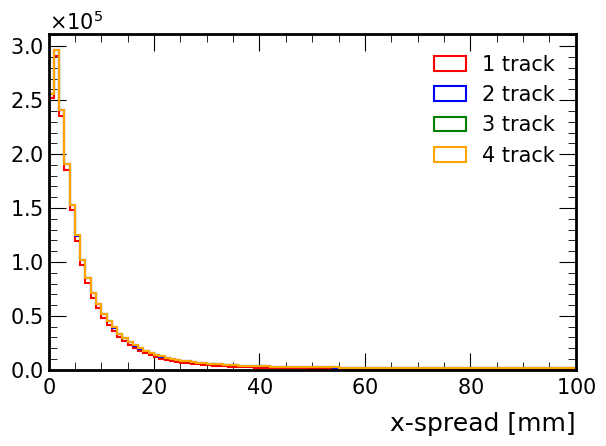

In [71]:
one_track = (ak.num(cry_data["trk"]["trk.pdg"], axis=-1) <= 4)
two_track = (ak.num(cry_data["trk"]["trk.pdg"], axis=-1) <= 8)
three_track = (ak.num(cry_data["trk"]["trk.pdg"], axis=-1) <= 12)
four_track = (ak.num(cry_data["trk"]["trk.pdg"], axis=-1) <= 16)

plotter.plot_1D_overlay(
    {
        "1 track" : ak.flatten(cry_data["dev"]["x_spread"][one_track], axis=None),
        "2 track" : ak.flatten(cry_data["dev"]["x_spread"][two_track], axis=None),
        "3 track" : ak.flatten(cry_data["dev"]["x_spread"][three_track], axis=None),
        "4 track" : ak.flatten(cry_data["dev"]["x_spread"][four_track], axis=None),
    },
    nbins = 100,
    xmin = 0,
    xmax = 100,
    log_y = False,
    xlabel = "x-spread [mm]"
)

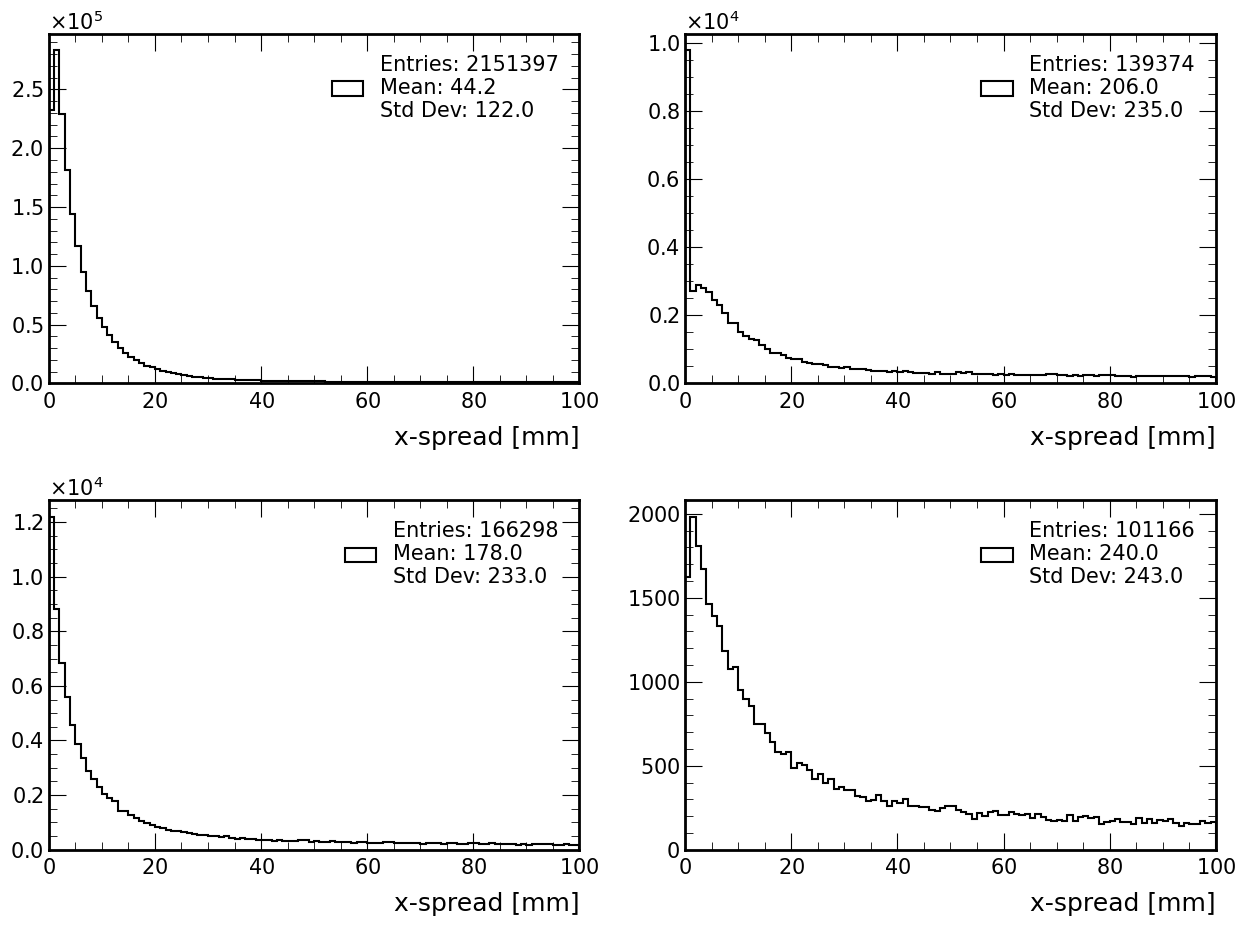

In [62]:
fig, ax = plt.subplots(2, 2, figsize=(2*6.4, 2*4.8))

condition = (ak.num(cry_data["trk"]["trk.pdg"], axis=-1) % 4 == 0)
plotter.plot_1D(
    ak.flatten(cry_data["dev"]["x_spread"][condition], axis=None),
    nbins = 100,
    xmin = 0,
    xmax = 100,
    show = False,
    log_y = False,
    xlabel = "x-spread [mm]",
    ax = ax[0, 0]
)

condition = (ak.num(cry_data["trk"]["trk.pdg"], axis=-1) % 4 == 1)
plotter.plot_1D(
    ak.flatten(cry_data["dev"]["x_spread"][condition], axis=None),
    nbins = 100,
    xmin = 0,
    xmax = 100,
    show = False,
    log_y = False,
    xlabel = "x-spread [mm]",
    ax = ax[0, 1]
)

condition = (ak.num(cry_data["trk"]["trk.pdg"], axis=-1) % 4 == 2)
plotter.plot_1D(
    ak.flatten(cry_data["dev"]["x_spread"][condition], axis=None),
    nbins = 100,
    xmin = 0,
    xmax = 100,
    show = False,
    log_y = False,
    xlabel = "x-spread [mm]",
    ax = ax[1, 0]
)

condition = (ak.num(cry_data["trk"]["trk.pdg"], axis=-1) % 4 == 3)
plotter.plot_1D(
    ak.flatten(cry_data["dev"]["x_spread"][condition], axis=None),
    nbins = 100,
    xmin = 0,
    xmax = 100,
    show = False,
    log_y = False,
    xlabel = "x-spread [mm]",
    ax = ax[1, 1]
)

plt.tight_layout()
plt.show()

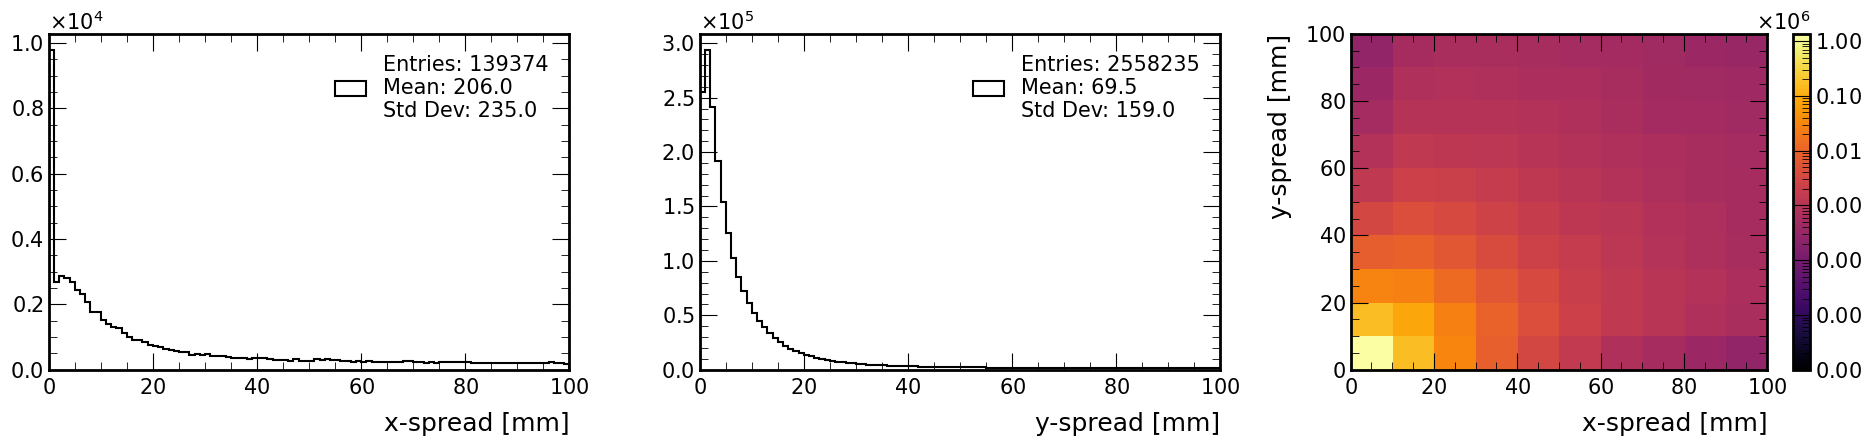

In [49]:
# Plot x-y spread
fig, ax = plt.subplots(1, 3, figsize=(3*6.4, 4.8))

plotter.plot_1D(
    ak.flatten(cry_data["dev"]["x_spread"][(ak.num(cry_data["trk"]["trk.pdg"], axis=-1) % 4 == 1)], axis=None),
    nbins = 100,
    xmin = 0,
    xmax = 100,
    show = False,
    log_y = False,
    xlabel = "x-spread [mm]",
    ax = ax[0]
)

plotter.plot_1D(
    ak.flatten(cry_data["dev"]["y_spread"], axis=None),
    nbins = 100,
    xmin = 0,
    xmax = 100,
    show = False,
    log_y = False,
    xlabel = "y-spread [mm]",
    ax = ax[1]
)

plotter.plot_2D(
    x = ak.flatten(cry_data["dev"]["x_spread"], axis=None),
    y = ak.flatten(cry_data["dev"]["y_spread"], axis=None),
    nbins_x = 10,
    xmin = 0,
    xmax = 100,
    nbins_y = 10,
    ymin = 0,
    ymax = 100,
    show = False,
    log_z = True,
    xlabel = "x-spread [mm]",
    ylabel = "y-spread [mm]",
    ax = ax[2]
)

plt.tight_layout()
plt.savefig("img.png")
plt.show()

In [9]:
def define_cuts(data):
    ###################################################
    # Count physical tracks via entrance clustering
    ###################################################
    try:
        # Get track segments at tracker entrance
        at_trk_front = selector.select_surface(data["trkfit"], surface_name="TT_Front")
        front_segs = data["trkfit"]["trksegs"][at_trk_front]
        
        # Extract entrance position for each hypothesis
        # These are the spatial coordinates at TT_Front
        x_front = front_segs["pos"]["fCoordinates"]["fX"]
        y_front = front_segs["pos"]["fCoordinates"]["fY"]
        z_front = front_segs["pos"]["fCoordinates"]["fZ"]
    
        # # For hypotheses of the SAME physical track:
        # # positions will be identical (within fit precision, ~mm)
        # # 
        # # Strategy: Take the first (or any) valid hypothesis's entrance position
        # # as the "track anchor", then count unique anchors
        
        # Flatten to get one position per hypothesis, then check variance
        x_first = ak.firsts(x_front, axis=-1)  # one x per hypothesis
        y_first = ak.firsts(y_front, axis=-1)

        data = append_array(data, x_first, "x_first")
        
        # Group hypotheses by matching (x,y) at entrance
        # If all hypotheses have the same entrance (within tolerance), it's 1 track
        x_spread = ak.max(x_first, axis=-1) - ak.min(x_first, axis=-1)
        y_spread = ak.max(y_first, axis=-1) - ak.min(y_first, axis=-1)

        data = append_array(data, x_first, "x_first")
        data = append_array(data, x_first, "x_first")
        
        # Tolerance: hypotheses from same track should match within ~1mm
        position_tolerance = 1.0 # mm, tune based on your resolution
        single_physical_track = (x_spread < position_tolerance) & (y_spread < position_tolerance)
        
        cut.add_cut(
            name="single_physical_track",
            description="All hypotheses consistent with single physical track (entrance clustering)",
            mask=single_physical_track,
            group="Preselect",
            active=True
        )
        
    except Exception as e:
        logger.log(f"Error defining 'single_physical_track' cut: {e}", "error")
        raise e
        
    return data

cry_data = define_cuts(cry_data)

[pyselect] ✅ Returning mask for trksegs with sid = 0


In [10]:
printer.print_n_events(cry_data, 1)

[pyprint] ⭐️ Printing 1 event(s)...

-------------------------------------------------------------------------------------
evt.run: 1202
evt.subrun: 68
evt.event: 22194
trk.trk.pdg: [11, 11, -11, -11, 11, 13, -13, 13, -13, -13, -13]
trk.trkqual.result: [0.793, 0.84, 0.452, 0.0936, 0.0125, ..., 0.0127, 0.148, 0.0586, 0.102, 0.0143]
trkfit.trksegs.mom.fCoordinates.fX: [[52.7, -29.6, -2.86, -42.3, 29.7], [...], ..., [6.86, 2.82, -8.85, -30.2]]
trkfit.trksegs.mom.fCoordinates.fY: [[13.3, 37.8, 48.6, 20.7, -58.2], [-44.1, ...], ..., [-30.6, 30.5, 35.9, 18.8]]
trkfit.trksegs.mom.fCoordinates.fZ: [[68.9, 72.7, 72.7, 72.9, 58.6], [80.6, ...], ..., [-52.6, -51, -51.4, -47.7]]
trkfit.trksegs.pos.fCoordinates.fX: [[80.1, 176, 210, 121, -68.6], [-126, ..., 24.8], ..., [141, -55, -97.2, -3.06]]
trkfit.trksegs.pos.fCoordinates.fY: [[289, 569, 478, 622, 296], [480, 470, ..., 480], ..., [549, 532, 492, 333]]
trkfit.trksegs.pos.fCoordinates.fZ: [[-3.25e+03, 10.1, -1.63e+03, 1.64e+03, -5.97e+03], ..., [

In [11]:
Print(True).print_n_events(cry_data["trkmc"], 1)

[pyprint] ⭐️ Initialised Print with verbose = True and precision = 1
[pyprint] ⭐️ Printing 1 event(s)...

-------------------------------------------------------------------------------------
trkmcsim.valid: [[True, True, True, True, True], [True, True, True, True, True, True], [True, True, True, True, True, True], [True, True, True, True, True], [True, True, True, True, True, True], [True, True, True, True, True], [True, True, True, True, True], [True, True, True, True, True, True], [True, True, True, True, True, True], [True, True, True, True, True], [True, True, True, True, True]]
trkmcsim.id: [[93, 0, 94, 92, 0], [92, 0, 94, 101, 93, 0], [92, 0, 94, 101, 93, 0], [93, 0, 94, 92, 0], [93, 0, 92, 94, 101, 0], [93, 0, 92, 94, 0], [92, 0, 94, 93, 0], [92, 0, 101, 94, 93, 0], [92, 0, 94, 101, 93, 0], [93, 0, 94, 92, 0], [93, 0, 92, 94, 0]]
trkmcsim.nhits: [[67, -1, 2, 2, -1], [62, -1, 14, 1, 7, -1], [64, -1, 6, 1, 2, -1], [67, -1, 2, 2, -1], [14, -1, 20, 4, 1, -1], [67, -1, 2, 2, -1], [2

In [6]:
cut = CutManager()

# Truth PDG electrons
# Best fit is an electron 
# One quality downstream track
# No quality upstream tracks 
# Select electrons

def define_cuts(data):
    """
    Test different versions of the downstream & 
    """
        ###################################################
        # Track "PID" from truth track parents 
        ###################################################
        try:
            # Truth track parent is electron 
            is_truth_electron = data["trkmc"]["trkmcsim"]["pdg"] == 11
            is_trk_parent = data["trkmc"]["trkmcsim"]["nhits"] == ak.max(data["trkmc"]["trkmcsim"]["nhits"], axis=-1)
            is_trk_parent_electron = is_truth_electron & is_trk_parent 
            has_trk_parent_electron = ak.any(is_trk_parent_electron, axis=-1) 
            # Add cut 
            cut.add_cut(
                name="truth_pid", 
                description="Track parents are electrons (truth PID)", 
                mask=has_trk_parent_electron,
                group="Preselect",
                active=True
            )
            # Append for debugging
            data = _append_array(data, has_trk_parent_electron, "has_trk_parent_electron")

        except Exception as e:
            logger.log(f"Error defining 'is_truth_electron' cut: {e}", "error") 
            raise e 
            
        ###################################################
        # Tracks intersect tracker 
        ###################################################
        try: 
            # Track segments level definition
            at_trk_front = selector.select_surface(data["trkfit"], surface_name="TT_Front") 
            at_trk_mid = selector.select_surface(data["trkfit"], surface_name="TT_Mid")
            at_trk_back = selector.select_surface(data["trkfit"], surface_name="TT_Back")
            in_trk = (at_trk_front | at_trk_mid | at_trk_back)
            
            # Track level definition 
            thru_trk = (
                ak.any(at_trk_front, axis=-1) &
                ak.any(at_trk_mid, axis=-1) &
                ak.any(at_trk_back, axis=-1) 
            )
            
            # Add cut 
            cut.add_cut(
                name="thru_trk", 
                description="Tracks intersect full tracker", 
                mask=thru_trk,
                group="Preselect",
                active=True
            )
            
            # Append for debugging
            data = _append_array(data, thru_trk, "thru_trk")
            
        except Exception as e:
            logger.log(f"Error defining 'thru_trk' cut: {e}", "error") 
            raise e
            
        ###################################################
        # Track fit hypothesis quality
        # Require good track hypotheses 
        ###################################################
        try: 
            # Track level mask
            good_trkqual = selector.select_trkqual(data["trk"], quality=0.2)
            # Add cut 
            cut.add_cut(
                name="good_trkqual",
                description=f"Track quality > 0.2",
                mask=good_trkqual,
                group="Preselect",
                active=True
            )
            # Append for debugging
            data = _append_array(data, good_trkqual, "good_trkqual")
        except Exception as e:
            logger.log(f"Error defining 'good_trkqual' cut: {e}", "error") 
            raise e

        ###################################################
        # Select electron track fit hypothesis  
        ###################################################
        try:
            # Track level definition
            is_reco_electron = selector.is_electron(data["trk"])
            # Add cut 
            cut.add_cut(
                name="is_reco_electron", 
                description="Select electron track", 
                mask=is_reco_electron,
                group="Preselect",
                active=True
            )
            # Append mask for debugging
            # data = _append_array(data, is_reco_electron, "is_reco_electron")
        except Exception as e:
            logger.log(f"Error defining 'is_reco_electron' cut: {e}", "error") 
            raise e

        ###################################################
        # Best fit is an electron
        ###################################################
        try:
            trkqual = data["trk"]["trkqual.result"] 
            pdgs = data["trk"]["trk.pdg"]
            best_trkqual_idx = ak.argmax(trkqual, axis=-1, keepdims=True)
            best_fit_pdg = ak.firsts(pdgs[ak.local_index(pdgs) == best_trkqual_idx])
            best_fit_electron = best_fit_pdg == 11
            
            # Add cut 
            cut.add_cut(
                name="best_fit_electron", 
                description="Best fit is an electron", 
                mask=best_fit_electron,
                group="Preselect",
                active=True
            )
            # Append mask for debugging
            data = _append_array(data, best_trkqual_idx, "best_trkqual_idx")
            data = _append_array(data, best_fit_pdg, "best_fit_pdg")
            data = _append_array(data, best_fit_electron, "best_fit_electron")
        except Exception as e:
            logger.log(f"Error defining 'best_fit_electron' cut: {e}", "error") 
            raise e

        ###################################################
        # One quality downstream track 
        ###################################################
        try: 
            # Trajectory is signed by charge
            pdgs = data["trk"]["trk.pdg"]
            q = -1 * data["trk"]["trk.pdg"]/abs(data["trk"]["trk.pdg"])
            p_z = data["trkfit"]["trksegs"]["mom"]["fCoordinates"]["fZ"]
            q_p_z = q * p_z

            downstream_seg = p_z > 0 # segs
            downstream_trk = ak.all(~in_trk | downstream_seg, axis=-1) # hypos
            # downstream_qual_trk = ak.all(~good_trkqual | downstream_trk, axis=-1)
            
            # Add cut 
            cut.add_cut(
                name="downstream_trk",
                description=f"Quality tracks are downstream (p_z > 0 thru tracker)",
                mask=downstream_trk,
                group="Preselect",
                active=True
            )
            # Append for debugging
            data = _append_array(data, downstream_trk, "downstream_trk")
            
        except Exception as e:
            logger.log(f"Error defining 'downstream_trk' cut: {e}", "error") 
            raise e

        return data

In [13]:
# cut = CutManager()
# def define_cuts_nominal(data):
#         ###################################################
#         # Track "PID" from truth track parents 
#         ###################################################
#         try:
#             # Truth track parent is electron 
#             is_truth_electron = data["trkmc"]["trkmcsim"]["pdg"] == 11
#             is_trk_parent = data["trkmc"]["trkmcsim"]["nhits"] == ak.max(data["trkmc"]["trkmcsim"]["nhits"], axis=-1)
#             is_trk_parent_electron = is_truth_electron & is_trk_parent 
#             has_trk_parent_electron = ak.any(is_trk_parent_electron, axis=-1) 
#             # Add cut 
#             cut.add_cut(
#                 name="truth_pid", 
#                 description="Track parents are electrons (truth PID)", 
#                 mask=has_trk_parent_electron,
#                 group="Preselect",
#                 active=True
#             )
#             # Append for debugging
#             data = _append_array(data, has_trk_parent_electron, "has_trk_parent_electron")

#         except Exception as e:
#             logger.log(f"Error defining 'is_truth_electron' cut: {e}", "error") 
#             raise e 
            
#         ###################################################
#         # Tracks intersect tracker 
#         ###################################################
#         try: 
#             # Track segments level definition
#             at_trk_front = selector.select_surface(data["trkfit"], surface_name="TT_Front") 
#             at_trk_mid = selector.select_surface(data["trkfit"], surface_name="TT_Mid")
#             at_trk_back = selector.select_surface(data["trkfit"], surface_name="TT_Back")
#             in_trk = (at_trk_front | at_trk_mid | at_trk_back)
            
#         except Exception as e:
#             logger.log(f"Error defining tracker surface masks: {e}", "error") 
#             raise e
            
#         try:
#             # Track level definition 
#             thru_trk = (
#                 ak.any(at_trk_front, axis=-1) &
#                 ak.any(at_trk_mid, axis=-1) &
#                 ak.any(at_trk_back, axis=-1) 
#             )
            
#             # Add cut 
#             cut.add_cut(
#                 name="thru_trk", 
#                 description="Tracks intersect full tracker", 
#                 mask=thru_trk,
#                 group="Preselect",
#                 active=True
#             )
            
#             # Append for debugging
#             data = _append_array(data, thru_trk, "thru_trk")
            
#         except Exception as e:
#             logger.log(f"Error defining 'thru_trk' cut: {e}", "error") 
#             raise e

#         ###################################################
#         # No duplicate hypotheses
#         # This implies multiple clusters of tracker hits
#         ###################################################
#         try:

#             # Count unique pdgs
#             pdgs = data["trk"]["trk.pdg"]
#             n_unique_pdgs = ak.num(ak.run_lengths(ak.sort(pdgs)), axis=-1)
#             n_total_pdgs = ak.num(pdgs, axis=-1)
#             has_duplicates = n_unique_pdgs < n_total_pdgs
#             no_duplicates = ~has_duplicates
        
#             # Add cut 
#             cut.add_cut(
#                 name="no_duplicates",
#                 description="No duplicate track hypotheses",
#                 mask=no_duplicates,
#                 group="Preselect",
#                 active=True
#             )

#             # Append for debugging
#             data = _append_array(data, no_duplicates, "no_duplicates")

#         except Exception as e:
#             logger.log(f"Error defining 'no_duplicates' cut: {e}", "error") 
#             raise e

#         ###################################################
#         # Best fit is an electron
#         ###################################################
#         try:
#             trkqual = data["trk"]["trkqual.result"] 
#             best_trkqual_idx = ak.argmax(trkqual, axis=-1, keepdims=True)
#             best_fit_pdg = ak.firsts(pdgs[ak.local_index(pdgs) == best_trkqual_idx])
#             best_fit_electron = best_fit_pdg == 11
            
#             # Add cut 
#             cut.add_cut(
#                 name="best_fit_electron", 
#                 description="Best fit is an electron", 
#                 mask=best_fit_electron,
#                 group="Preselect",
#                 active=True
#             )
#             # Append mask for debugging
#             data = _append_array(data, best_trkqual_idx, "best_trkqual_idx")
#             data = _append_array(data, best_fit_pdg, "best_fit_pdg")
#             data = _append_array(data, best_fit_electron, "best_fit_electron")
#         except Exception as e:
#             logger.log(f"Error defining 'best_fit_electron' cut: {e}", "error") 
#             raise e

#         ###################################################
#         # Select electron track fit hypothesis  
#         ###################################################
#         try:
#             # Track level definition
#             is_reco_electron = selector.is_electron(data["trk"])
#             # Add cut 
#             cut.add_cut(
#                 name="is_reco_electron", 
#                 description="Select electron track", 
#                 mask=is_reco_electron,
#                 group="Preselect",
#                 active=True
#             )
#             # Append mask for debugging
#             # data = _append_array(data, is_reco_electron, "is_reco_electron")
#         except Exception as e:
#             logger.log(f"Error defining 'is_reco_electron' cut: {e}", "error") 
#             raise e

#         ###################################################
#         # Track fit hypothesis quality
#         # Require good track hypotheses 
#         ###################################################
#         try: 
#             # Track level mask
#             good_trkqual = selector.select_trkqual(data["trk"], quality=0.2)
#             # Add cut 
#             cut.add_cut(
#                 name="good_trkqual",
#                 description=f"Track quality > 0.2",
#                 mask=good_trkqual,
#                 group="Preselect",
#                 active=True
#             )
#             # Append for debugging
#             data = _append_array(data, good_trkqual, "good_trkqual")
#         except Exception as e:
#             logger.log(f"Error defining 'good_trkqual' cut: {e}", "error") 
#             raise e

#         ###################################################
#         # Quality downstream tracks 
#         ###################################################
#         try: 
#             # Trajectory is signed by charge
#             q = -1 * data["trk"]["trk.pdg"]/abs(data["trk"]["trk.pdg"])
#             p_z = data["trkfit"]["trksegs"]["mom"]["fCoordinates"]["fZ"]
#             q_p_z = q * p_z

#             downstream_seg = q_p_z > 0 # segs
#             downstream_trk = ak.all(~in_trk | is_downstream, axis=-1) # hypos
#             downstream_qual_trk = ak.all(~good_trkqual | all_downstream, axis=-1)
            
#             # Add cut 
#             cut.add_cut(
#                 name="downstream_qual_trk",
#                 description=f"Quality tracks are downstream (p_z > 0 thru tracker)",
#                 mask=all_downstream,
#                 group="Preselect",
#                 active=True
#             )
#             # Append for debugging
#             data = _append_array(data, all_downstream, "all_downstream")
            
#         except Exception as e:
#             logger.log(f"Error defining 'all_downstream' cut: {e}", "error") 
#             raise e

#         return data

[pycut] ✅ Initialised


In [39]:
cut = CutManager()

# Truth PDG electrons
# Best fit is an electron 
# One quality downstream track
# No quality upstream tracks 
# Select electrons

def define_cuts(data):
    """
    Test different versions of the downstream & 
    """
        ###################################################
        # Track "PID" from truth track parents 
        ###################################################
        try:
            # Truth track parent is electron 
            is_truth_electron = data["trkmc"]["trkmcsim"]["pdg"] == 11
            is_trk_parent = data["trkmc"]["trkmcsim"]["nhits"] == ak.max(data["trkmc"]["trkmcsim"]["nhits"], axis=-1)
            is_trk_parent_electron = is_truth_electron & is_trk_parent 
            has_trk_parent_electron = ak.any(is_trk_parent_electron, axis=-1) 
            # Add cut 
            cut.add_cut(
                name="truth_pid", 
                description="Track parents are electrons (truth PID)", 
                mask=has_trk_parent_electron,
                group="Preselect",
                active=True
            )
            # Append for debugging
            data = _append_array(data, has_trk_parent_electron, "has_trk_parent_electron")

        except Exception as e:
            logger.log(f"Error defining 'is_truth_electron' cut: {e}", "error") 
            raise e 
            
        ###################################################
        # Tracks intersect tracker 
        ###################################################
        try: 
            # Track segments level definition
            at_trk_front = selector.select_surface(data["trkfit"], surface_name="TT_Front") 
            at_trk_mid = selector.select_surface(data["trkfit"], surface_name="TT_Mid")
            at_trk_back = selector.select_surface(data["trkfit"], surface_name="TT_Back")
            in_trk = (at_trk_front | at_trk_mid | at_trk_back)
            
            # Track level definition 
            thru_trk = (
                ak.any(at_trk_front, axis=-1) &
                ak.any(at_trk_mid, axis=-1) &
                ak.any(at_trk_back, axis=-1) 
            )
            
            # Add cut 
            cut.add_cut(
                name="thru_trk", 
                description="Tracks intersect full tracker", 
                mask=thru_trk,
                group="Preselect",
                active=True
            )
            
            # Append for debugging
            data = _append_array(data, thru_trk, "thru_trk")
            
        except Exception as e:
            logger.log(f"Error defining 'thru_trk' cut: {e}", "error") 
            raise e
            
        ###################################################
        # Track fit hypothesis quality
        # Require good track hypotheses 
        ###################################################
        try: 
            # Track level mask
            good_trkqual = selector.select_trkqual(data["trk"], quality=0.2)
            # Add cut 
            cut.add_cut(
                name="good_trkqual",
                description=f"Track quality > 0.2",
                mask=good_trkqual,
                group="Preselect",
                active=True
            )
            # Append for debugging
            data = _append_array(data, good_trkqual, "good_trkqual")
        except Exception as e:
            logger.log(f"Error defining 'good_trkqual' cut: {e}", "error") 
            raise e

        ###################################################
        # Select electron track fit hypothesis  
        ###################################################
        try:
            # Track level definition
            is_reco_electron = selector.is_electron(data["trk"])
            # Add cut 
            cut.add_cut(
                name="is_reco_electron", 
                description="Select electron track", 
                mask=is_reco_electron,
                group="Preselect",
                active=True
            )
            # Append mask for debugging
            # data = _append_array(data, is_reco_electron, "is_reco_electron")
        except Exception as e:
            logger.log(f"Error defining 'is_reco_electron' cut: {e}", "error") 
            raise e

        ###################################################
        # Best fit is an electron
        ###################################################
        try:
            trkqual = data["trk"]["trkqual.result"] 
            pdgs = data["trk"]["trk.pdg"]
            best_trkqual_idx = ak.argmax(trkqual, axis=-1, keepdims=True)
            best_fit_pdg = ak.firsts(pdgs[ak.local_index(pdgs) == best_trkqual_idx])
            best_fit_electron = best_fit_pdg == 11
            
            # Add cut 
            cut.add_cut(
                name="best_fit_electron", 
                description="Best fit is an electron", 
                mask=best_fit_electron,
                group="Preselect",
                active=True
            )
            # Append mask for debugging
            data = _append_array(data, best_trkqual_idx, "best_trkqual_idx")
            data = _append_array(data, best_fit_pdg, "best_fit_pdg")
            data = _append_array(data, best_fit_electron, "best_fit_electron")
        except Exception as e:
            logger.log(f"Error defining 'best_fit_electron' cut: {e}", "error") 
            raise e

        ###################################################
        # One quality downstream track 
        ###################################################
        try: 
            # Trajectory is signed by charge
            pdgs = data["trk"]["trk.pdg"]
            q = -1 * data["trk"]["trk.pdg"]/abs(data["trk"]["trk.pdg"])
            p_z = data["trkfit"]["trksegs"]["mom"]["fCoordinates"]["fZ"]
            q_p_z = q * p_z

            downstream_seg = p_z > 0 # segs
            downstream_trk = ak.all(~in_trk | downstream_seg, axis=-1) # hypos
            # downstream_qual_trk = ak.all(~good_trkqual | downstream_trk, axis=-1)
            
            # Add cut 
            cut.add_cut(
                name="downstream_trk",
                description=f"Quality tracks are downstream (p_z > 0 thru tracker)",
                mask=downstream_trk,
                group="Preselect",
                active=True
            )
            # Append for debugging
            data = _append_array(data, downstream_trk, "downstream_trk")
            
        except Exception as e:
            logger.log(f"Error defining 'downstream_trk' cut: {e}", "error") 
            raise e

        return data

[pycut] ✅ Initialised


In [40]:
cry_data_nom = define_cuts_nominal(cry_data)
#ce_data_nom = define_cuts_nominal(ce_data)

[pycut] ⭐️ Added cut truth_pid with index 0 in group 'Preselect'
[pyselect] ✅ Returning mask for trksegs with sid = 0
[pyselect] ✅ Returning mask for trksegs with sid = 1
[pyselect] ✅ Returning mask for trksegs with sid = 2
[pycut] ⭐️ Added cut thru_trk with index 1 in group 'Preselect'
[pyselect] ✅ Returning mask for trkqual > 0.2
[pycut] ⭐️ Added cut good_trkqual with index 2 in group 'Preselect'
[pyselect] ✅ Returning mask for e- tracks
[pycut] ⭐️ Added cut is_reco_electron with index 3 in group 'Preselect'
[pycut] ⭐️ Added cut best_fit_electron with index 4 in group 'Preselect'
[pycut] ⭐️ Added cut downstream_trk with index 5 in group 'Preselect'


In [41]:
def df_cut_flow(data):
    cut_flow = cut.create_cut_flow(data)
    df_cut_flow = cut.format_cut_flow(cut_flow)
    display(df_cut_flow)
    return df_cut_flow

df_cry_nom_cf = df_cut_flow(cry_data_nom)

,Cut,Group,Events Passing,Absolute [%],Relative [%],Description
0,No cuts,N/A,2610933,100.00,100.00,No selection applied
1,truth_pid,Preselect,622896,23.86,23.86,Track parents are electrons (truth PID)
2,thru_trk,Preselect,619249,23.72,99.41,Tracks intersect full tracker
3,good_trkqual,Preselect,484637,18.56,78.26,Track quality > 0.2
4,is_reco_electron,Preselect,474927,18.19,98.00,Select electron track
5,best_fit_electron,Preselect,432878,16.58,91.15,Best fit is an electron
6,downstream_trk,Preselect,324634,12.43,74.99,Quality tracks are downstream (p_z > 0 thru tr...


In [42]:
printer.print_n_events(cry_data_nom["trk"])
printer.print_n_events(cry_data_nom["dev"])

[pyprint] ⭐️ Printing 1 event(s)...

-------------------------------------------------------------------------------------
trk.pdg: [11, 11, -11, -11, 11, 13, -13, 13, -13, -13, -13]
trkqual.result: [0.793, 0.84, 0.452, 0.0936, 0.0125, ..., 0.0127, 0.148, 0.0586, 0.102, 0.0143]
-------------------------------------------------------------------------------------

[pyprint] ⭐️ Printing 1 event(s)...

-------------------------------------------------------------------------------------
has_trk_parent_electron: [True, True, True, True, True, True, True, True, True, True, True]
thru_trk: [True, True, True, True, True, True, True, True, True, True, True]
good_trkqual: [True, True, True, False, False, True, False, False, False, False, False]
best_trkqual_idx: [1]
best_fit_pdg: 11
best_fit_electron: True
downstream_trk: [True, True, False, False, False, True, True, True, False, False, False]
-------------------------------------------------------------------------------------

